<a target="_blank" href="https://colab.research.google.com/github/NMRLipids/databank-template/blob/main/scripts/FormFactor_to_TotalDensity_model_training_walkthrough.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Training a neural network to predict total density using form factor
This notebook shows how a neural network can be trained to predict total density profiles from form factors.  
It contains the following steps: 
1) Download the data using the [NMR lipids API](https://nmrlipids.github.io/databankLibrary.html).  
2) Explore the data, and preprocess the data for the machine learning pipeline.  
3) Split data into train and test sets.
4) Train and evaluate the performance of the neural network. 

Variable descriptions from the [NMRlipids databank](https://nmrlipids.github.io/listOfFiles.html#):  
* Total densities: Total electron densities calculated with calc_FormFactors.py and stored in /Data/Simulations for all simulations. X-axis units are nm and y-axis units e/nm3.  
* Form factors: X-ray scattering calculated with calc_FormFactors.py and stored in /Data/Simulations for all simulations. X-axis value unit are Å-1 and y-axis value units are e/nm2.  

### Download and initialize the NMR lipids databank
To access the NMR lipids databank, clone the NMRlipids databank git repository into your working folder as explained at https://nmrlipids.github.io/databankLibrary.html 
```
git clone https://github.com/NMRLipids/Databank.git
```
After doing so, the following code block sets up the databank for use.

## Set up the environment, download the NMR lipids Database, and prepare the data

### Load the required libraries
Create a virtual environment using e.g. Poetry, and install the following libraries that will be needed. 
The code block below loads the required libraries if they are available in the virtual environment. If errors are generated, check the available libraries e.g. using pip list and install whichever libraries are missing.

In [1]:
# Initialize the NMR lipids databank

import sys
import os

databankPath = "/home/sosamuli/work/NMRlipids/Databank/"  # this is the local path for the cloned Databank
os.environ["NMLDB_ROOT_PATH"] = databankPath

if 'google.colab' in sys.modules:
    !git clone https://github.com/NMRlipids/Databank
    %cd Databank
    !sed -i '/numpy/s/^/# /' Scripts/DatabankLib/requirements.txt
    !pip3 install .
    os.environ["NMLDB_ROOT_PATH"] = "/content/Databank"
    databankPath = "/content/Databank"
    !pip3 install scikeras

# This enables the access to functions defined in the NMRlipids databank.
sys.path.insert(1, databankPath + "/Scripts/")
from DatabankLib.plottings import *

# This initializes the databank and stores the information of all simulations into a list.
# Each list item contains the information from README.yaml file of the given simulation.
from DatabankLib.core import initialize_databank

systems = initialize_databank()

/home/sosamuli/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Databank initialized from the folder: /home/sosamuli/work/NMRlipids/Databank/Data/Simulations


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor

import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from tensorflow.python.keras.callbacks import EarlyStopping

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter("ignore", ConvergenceWarning)


os.environ["TF_CPP_MIN_LOG_LEVEL"] = (
    "3"  # Set TensorFlow verbosity to lowest (only print errors)
)

2025-05-14 17:43:00.860907: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-14 17:43:00.861372: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-14 17:43:00.863816: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-14 17:43:00.869793: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747233780.880223  164240 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747233780.88

### Initialize a random number generator
This will be used to split the data into training and test sets reproducibly. 

In [3]:
seed = 43715679334954349782040625626900603510
rng = np.random.default_rng(seed)

In [4]:
print("Total number of system in this version of the Databank:", len(systems))

Total number of system in this version of the Databank: 808


In [5]:
from DatabankLib.databankLibrary import *  # is needed for getHydrationLevel() function

In [6]:
# Import new functions that have not yet been added to DatabankLib
if 'google.colab' in sys.modules:
  %cd ../
  !git clone https://github.com/NMRLipids/databank-template.git
  %cd Databank
  sys.path.append('/content/databank-template/scripts')
    
from new_functions import *

### Inclusion criteria
Systems are excluded if either of these occur:   
- There are warnings about:  
    - periodic boundary condition (PBC)  
    - or x-normal orientation  
- There is too little water in the simulation
- Equilibration time is too large for any of the lipids in the system

In [7]:
# Some systems have periodic boundary condition (PBC) warnings and should be excluded from the analysis
PBC_warning_count = 0
xnormal_warning_count = 0
for system in systems:
    if "WARNINGS" in system.keys() and type(system["WARNINGS"]) == dict:
        if "PBC" in system["WARNINGS"].keys():
            PBC_warning_count += 1
            # print("System ", system["ID"], ": ", system["WARNINGS"], sep="")
        if (
            "ORIENTATION" in system["WARNINGS"].keys()
            and system["WARNINGS"]["ORIENTATION"] == "x-normal"
        ):
            xnormal_warning_count += 1
            # print("System ", system["ID"], ": ", system["WARNINGS"], sep="")
print("Number of systems with PBC warnings:", PBC_warning_count)
print("Number of systems with xnormal warnings:", xnormal_warning_count)

Number of systems with PBC warnings: 18
Number of systems with xnormal warnings: 3


In [8]:
# Exclude based on water/lipid ratio
water_to_lipid_ratio_threshold = 20
little_water_systems = 0
for system in systems:
    try:
        water_to_lipid_ratio = getHydrationLevel(system)
    except NameError:
        sys.exit(
            "Could not find function getHydrationLevel. Check your path inclusions."
        )
    except Exception:
        continue  # Exclude the system due to not having a recorded water to lipid ratio, and move to the next system
    # print(water_to_lipid_ratio)
    if water_to_lipid_ratio <= water_to_lipid_ratio_threshold:
        little_water_systems += 1
print("Number of systems with too little water:", little_water_systems)

Number of systems with too little water: 34


In [9]:
# Count how many systems have long equilibration times
eq_time_threshold = 1
high_eq_times_counter = 0
for system in systems:
    eq_times = get_equilibration_times(system, databankPath, error_strategy="ignore")
    if eq_times is not None and any(
        time > eq_time_threshold for time in eq_times.values()
    ):
        high_eq_times_counter += 1
        continue
print(
    "Number of systems with too high equilibration time for some lipid:",
    high_eq_times_counter,
)

Number of systems with too high equilibration time for some lipid: 321


Now we extract the form factor (ff) and total density (td) data of each simulation from the "system" variables.  
Each form factor has a shape of (1000), but the total densities have dimensions that vary.  
The total densities are split into separate lists td_x and td_y.  

In [10]:
# Use the inclusion criteria to select the systems we want in our analysis
system_ids = []
all_ff = []
all_td_x = []
all_td_y = []
td_x_lengths = []
td_y_lengths = []

# Complete data should have form factors of length 1000
required_form_factor_dimension = 1000

# Load form factors and total densities
for system in systems:
    # Exclude systems with warnings about periodic boundary conditions (PBC) or x-normal orientation watnings
    if "WARNINGS" in system.keys() and type(system["WARNINGS"]) == dict:
        if "PBC" in system["WARNINGS"].keys():
            continue  # Exclude system with PBC warnings and move to the next system
        elif (
            "ORIENTATION" in system["WARNINGS"].keys()
            and system["WARNINGS"]["ORIENTATION"] == "x-normal"
        ):
            continue  # Skip system with x-normal orientation warnings and move to the next system

    # Exclude systems with too low water to lipid ratio
    try:
        water_to_lipid_ratio = getHydrationLevel(system)
    except NameError:
        sys.exit(
            "Could not find function getHydrationLevel. Check your path inclusions."
        )
    except Exception:
        continue  # Exclude the system due to not having a recorded water to lipid ratio, and move to the next system
    if water_to_lipid_ratio <= water_to_lipid_ratio_threshold:
        continue  # Exclude this system due to having too low water to lipid ratio and move to the next system

    # Exclude systems with too long equilibration time for any lipid in eq_times
    eq_times = get_equilibration_times(system, databankPath, error_strategy="ignore")
    if eq_times is None:
        pass  # The system is included due to lack of contraindication
    else:  # If any of lipid in the system has too high eq_times, exclude the system
        if any(time > eq_time_threshold for time in eq_times.values()):
            continue  # Exclude this system due to having too long equilibration time

    # Load form factor and total density for the systems that pass the inclusion criteria
    form_factor_simulated, total_density_simulated = (
        get_form_factor_and_total_density_pair(
            system, databankPath, error_strategy="ignore"
        )
    )
    if (
        isinstance(form_factor_simulated, list)
        and isinstance(total_density_simulated, list)
        and len(form_factor_simulated) == required_form_factor_dimension
    ):
        system_ids.append(system["ID"])  # Add system ID to the list
        ff = np.array([elem[1] for elem in form_factor_simulated])
        all_ff.append(ff)  # Add form factor to the list

        td_x = np.array([elem[0] for elem in total_density_simulated])
        td_y = np.array([elem[1] for elem in total_density_simulated])
        all_td_x.append(td_x)  # Add total density x values to the list
        all_td_y.append(td_y)  # Add total density y values to the list
        td_x_lengths.append(len(td_x))
        td_y_lengths.append(len(td_y))

assert (
    len(system_ids) == len(all_ff) == len(all_td_x) == len(all_td_y)
)  # Be sure that there are as many form factors as total densitiess
assert (
    td_x_lengths == td_y_lengths
)  # Be sure that dimensions of x and y values match for every simulation
N_experiments = len(all_ff)
print("Number of form factor and total density pairs:", N_experiments)

Number of form factor and total density pairs: 457


In [11]:
# Sort all lists by system id
system_ids, all_ff, all_td_x, all_td_y, td_x_lengths, td_y_lengths = [
    list(elem)
    for elem in zip(
        *sorted(zip(system_ids, all_ff, all_td_x, all_td_y, td_x_lengths, td_y_lengths))
    )
]

## Get to know the data

It is important to take the time to get to know what the data looks like.  
Plotting different views of the data can identify corrupted data, mislabeled data, or point towards subgroups or structure in the data that can be exploited.

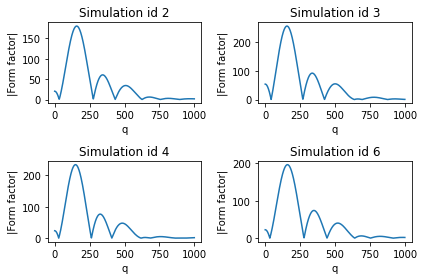

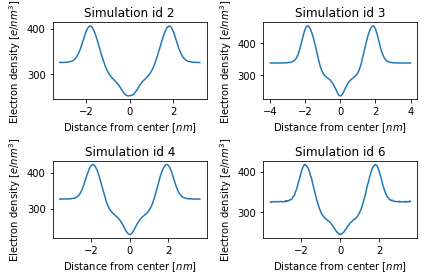

In [12]:
# Visualize form factors and total density profiles
# Rerun this block to cycle through different simulations, or use the line below to reset the plot counter
# start_of_plotting = 0

if "start_of_plotting" not in globals():
    start_of_plotting = 0

# Plot four density profiles
ff_fig, ff_axs = plt.subplots(nrows=2, ncols=2)
# plt.suptitle("Form factors of simulations " + str(start_of_plotting) + " to " + str(start_of_plotting+3))
ff_axs = ff_axs.flatten()

td_fig, td_axs = plt.subplots(nrows=2, ncols=2)
# plt.suptitle("Density profiles of simulations " + str(start_of_plotting) + " to " + str(start_of_plotting+3))
td_axs = td_axs.flatten()

x_axis_label_ff = "q"
y_axis_label_ff = "|Form factor|"
x_axis_label_td = "Distance from center [" + r"$nm$" + "]"
y_axis_label_td = "Electron density [" + r"$e/nm^3$" + "]"


plot_index = 0
for plot_counter, (system_id, x_vector, y_vector, ff_vector) in enumerate(
    zip(system_ids, all_td_x, all_td_y, all_ff)
):
    if plot_counter >= start_of_plotting:
        ff_axs[plot_index].plot(ff_vector)
        ff_axs[plot_index].set_title("Simulation id " + str(system_id))
        ff_axs[plot_index].set_xlabel(x_axis_label_ff)
        ff_axs[plot_index].set_ylabel(y_axis_label_ff)
        td_axs[plot_index].plot(x_vector, y_vector)
        td_axs[plot_index].set_xlabel(x_axis_label_td)
        td_axs[plot_index].set_ylabel(y_axis_label_td)
        td_axs[plot_index].set_title("Simulation id " + str(system_id))
        plot_index += 1
        if plot_index >= 4:
            start_of_plotting = plot_counter + 1
            break
ff_fig.tight_layout()
td_fig.tight_layout()

Looking through the simulations reveals the following facts about the data: 
- Some total densities are more smooth than others. 
- The x axis range of the total densities varies between simulations.
- Most density profiles have flat "shoulders", but not all: Some seem to be truncated in the x direction.

In [13]:
# Find the systems with narrow x dimension
narrow_limit = 3.0
narrow_td_system_ids = []
for system_id, x_vector, y_vector, ff_vector in zip(
    system_ids, all_td_x, all_td_y, all_ff
):
    if max(x_vector) < narrow_limit:
        narrow_td_system_ids.append(system_id)
print("Number of systems with narrow total densities:", len(narrow_td_system_ids))
print("IDs of systems with narrow total densities:", narrow_td_system_ids)

# Print the water/lipid ratio of the narrow systems
narrow_water_to_lipid_ratios = []
for system in systems:
    try:
        system["ID"]
    except:
        continue
    if system["ID"] in narrow_td_system_ids:
        try:
            water_to_lipid_ratio = getHydrationLevel(system)
        except NameError:
            sys.exit(
                "Could not find function getHydrationLevel. Check your path inclusions."
            )
        except Exception:
            continue  # Exclude the system due to not having a recorded water to lipid ratio, and move to the next system
        narrow_water_to_lipid_ratios.append(int(water_to_lipid_ratio))
        print(
            "System with ID",
            system["ID"],
            "has a water/lipid ratio of",
            water_to_lipid_ratio,
        )

Number of systems with narrow total densities: 6
IDs of systems with narrow total densities: [147, 158, 224, 277, 826, 827]
System with ID 147 has a water/lipid ratio of 28.5546875
System with ID 224 has a water/lipid ratio of 31.5625
System with ID 277 has a water/lipid ratio of 28.0
System with ID 158 has a water/lipid ratio of 31.09722222222222
System with ID 826 has a water/lipid ratio of 64.48484848484848
System with ID 827 has a water/lipid ratio of 31.625


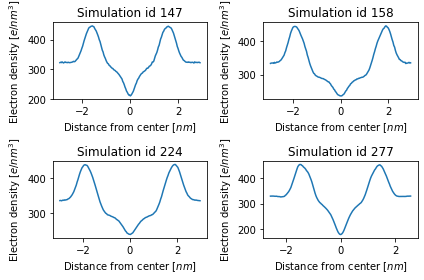

In [14]:
# Visualize the narrow systems
# Rerun this block to cycle through different simulations, or use the line below to reset the plot counter
# start_of_plotting_narrow_systems = 0

if "start_of_plotting_narrow_systems" not in globals():
    start_of_plotting_narrow_systems = 0

# Plot four density profiles
td_fig, td_axs = plt.subplots(nrows=2, ncols=2)
td_axs = td_axs.flatten()

plot_index = 0
for plot_counter, (system_id, x_vector, y_vector, ff_vector) in enumerate(
    zip(system_ids, all_td_x, all_td_y, all_ff)
):
    if (
        system_id in narrow_td_system_ids
        and plot_counter >= start_of_plotting_narrow_systems
    ):
        td_axs[plot_index].plot(x_vector, y_vector)
        td_axs[plot_index].set_xlabel(x_axis_label_td)
        td_axs[plot_index].set_ylabel(y_axis_label_td)
        td_axs[plot_index].set_title("Simulation id " + str(system_id))
        plot_index += 1
        if plot_index >= 4:
            start_of_plotting_narrow_systems = plot_counter + 1
            break
td_fig.tight_layout()

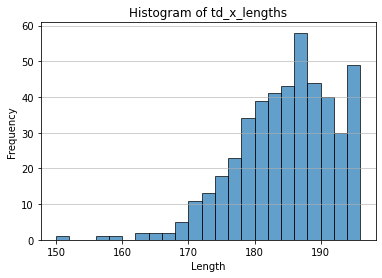

Every td_x length present in the dataset: {150, 156, 158, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196}
(The lenght of td_y matches td_x for each simulation)


In [15]:
# Visualize that the length of the total density data varies between simulations
plt.figure(figsize=(6, 4))
plt.hist(td_x_lengths, bins=23, edgecolor="black", alpha=0.7)
plt.title("Histogram of td_x_lengths")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.show()
print("Every td_x length present in the dataset:", set(td_x_lengths))
print("(The lenght of td_y matches td_x for each simulation)")

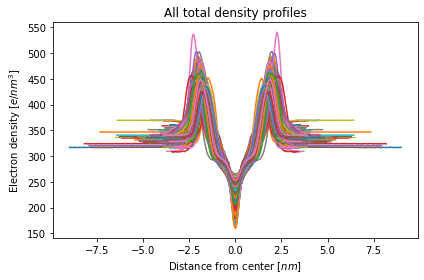

In [16]:
# Plot all total density profiles together
fig, ax = plt.subplots()
ax = plot_total_densities_to_ax(
    ax, all_td_x, all_td_y, x_axis_label_td, y_axis_label_td
)
plt.title("All total density profiles")
plt.tight_layout()
plt.show()

## Homogenize the data format of the total densities

The histogram of td_x_lengths shows that the different simulations have different numbers of observed values.  
Furthermore, the plot of total densities shows that some total densities have long flat tails while others are seemingly truncated in the x direction.  
Since the model fitting requires data with a uniform format, a preprocessing process is needed to define a common x grid for the density profiles.  

To select the x interval, one option is to constrict the x range to the most narrow observed experiment, but this leads to a loss of information for the wider experiments.  
Aother option is to only include the widest experiments, but this also leads to a large loss of data.  
A compromise could be to trim the shoulders of the widest simulations, and extrapolate the narrowest simulations a bit. 

In the following code block, an x interval centered around zero is chosen.  
Experiments that are narrower than this interval are extrapolated in the x direction in a simple way: using the y values at the ends of the observation window.  
This makes sure that all experiments have either actual measurements or extrapolated values across the entire x interval.  

Next, a Gaussian Process Regression is used to interpolate (predict values between points) on a uniform set of x coordinates that cover the x interval.  
This brings all the data on the same format. 

In [17]:
# Define start and end of the common x interval
# Systems that are more narrow than this will be extrapolated in the x direction (not ideal), and wider systems truncated (not ideal but not less critical)
x_interval_end = (
    narrow_limit  # This could be something else instead, like e.g. 3.7. Try it out
)
x_interval_start = -x_interval_end
length_of_padded_data = 400  # Total densities that are more narrow than the x interval will be padded on the sides to a total length of 400 values

padded_td_x = [
    extrapolate_X(td_x, length_of_padded_data, x_interval_start, x_interval_end)
    for td_x in all_td_x
]
padded_td_y = [extrapolate_Y(td_y, length_of_padded_data) for td_y in all_td_y]

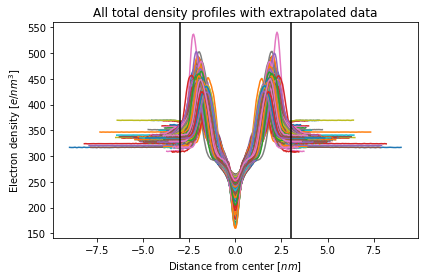

In [18]:
# Plot total density profiles
fig, ax = plt.subplots()
ax = plot_total_densities_to_ax(
    ax,
    padded_td_x,
    padded_td_y,
    x_axis_label_td,
    y_axis_label_td,
    lines=[x_interval_start, x_interval_end],
)
plt.title("All total density profiles with extrapolated data")
plt.tight_layout()
plt.show()

A Gaussian Process Regression is used to interpolate (predict values between points) on the uniform set of x coordinates.

In [19]:
# Interpolate with a Gaussian Process Regression to achieve a uniform x grid
uniform_x_range_dimension = 200

# Define the points for prediction
uniform_x_range = np.linspace(
    x_interval_start, x_interval_end, uniform_x_range_dimension
).reshape(-1, 1)

# Interpolate y values on the uniform x grid using Gaussian Process Regression (GPR)
standardized_y = interpolate_with_GPR(padded_td_x, padded_td_y, uniform_x_range)

Gather form factors and total densities in data frames.

In [20]:
# Convert the data to a pandas DataFrame and add the system_ids as index
sim_FF_df = pd.DataFrame(all_ff, index=system_ids)
sim_TD_y_df = pd.DataFrame(standardized_y, index=system_ids)

Get to know the data at a glance by calling the df name in a code block.

In [21]:
sim_FF_df

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2,20.400095,20.379938,20.319473,20.218725,20.077738,19.896568,19.675291,19.413999,19.112800,18.771819,...,1.827205,1.815026,1.802471,1.789549,1.776272,1.762650,1.748694,1.734414,1.719820,1.704925
3,54.014919,53.982579,53.885573,53.723944,53.497758,53.207113,52.852132,52.432965,51.949792,51.402818,...,0.093850,0.105642,0.141658,0.188558,0.240078,0.293803,0.348705,0.404281,0.460256,0.516460
4,23.701356,23.672345,23.585327,23.440341,23.237453,22.976756,22.658368,22.282435,21.849129,21.358646,...,1.374773,1.390022,1.404857,1.419274,1.433269,1.446836,1.459973,1.472674,1.484937,1.496758
6,22.504947,22.483457,22.418994,22.311585,22.161272,21.968114,21.732189,21.453589,21.132426,20.768828,...,1.959845,1.950184,1.939724,1.928476,1.916453,1.903665,1.890123,1.875841,1.860830,1.845102
11,3.181009,3.154011,3.073029,2.938103,2.749297,2.506704,2.210440,1.860651,1.457510,1.001226,...,1.342154,1.354454,1.366292,1.377666,1.388573,1.399011,1.408980,1.418477,1.427501,1.436053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,8.819620,8.794840,8.720520,8.596680,8.423370,8.200690,7.928700,7.607550,7.237350,6.818280,...,4.033980,3.957790,3.879410,3.798880,3.716240,3.631550,3.544840,3.456160,3.365560,3.273100
826,9.494640,9.512100,9.564460,9.651710,9.773810,9.930720,10.122400,10.348700,10.609600,10.905000,...,4.112360,4.090500,4.067060,4.042060,4.015520,3.987460,3.957900,3.926860,3.894350,3.860410
827,29.375300,29.358500,29.308400,29.224900,29.107900,28.957700,28.774100,28.557300,28.307300,28.024200,...,0.335276,0.323653,0.313433,0.304715,0.297582,0.292104,0.288323,0.286256,0.285888,0.287171
830,9.960740,9.936720,9.864690,9.744660,9.576700,9.360860,9.097240,8.785960,8.427120,8.020900,...,3.729770,3.624680,3.518300,3.410680,3.301860,3.191900,3.080860,2.968780,2.855730,2.741750


In [22]:
sim_TD_y_df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
2,326.265309,326.411108,326.583020,326.654106,326.720115,326.883686,327.120700,327.375485,327.664726,328.041373,...,328.139117,327.696642,327.275022,326.967647,326.824749,326.780321,326.694364,326.525172,326.377016,326.333856
3,339.149301,339.393025,339.448153,339.426392,339.501830,339.773843,340.251135,340.894537,341.614828,342.308280,...,342.111705,341.517629,340.849564,340.267094,339.962439,339.900057,339.729596,339.333545,338.890344,338.735841
4,327.483384,327.870549,328.283238,328.521794,328.663875,328.963951,329.571628,330.425840,331.411797,332.513632,...,332.471560,331.464386,330.587053,329.876555,329.319110,328.842180,328.412037,328.073652,327.835006,327.581490
6,326.362508,325.980965,325.846046,326.008529,326.229041,326.391523,326.730995,327.404137,328.019250,328.048264,...,327.155880,326.623460,326.607864,326.762186,326.737886,326.474215,326.191321,326.133292,326.301577,326.427792
11,336.553570,336.740897,336.976370,337.320058,337.803459,338.401953,339.074951,339.830388,340.732463,341.850346,...,341.920344,340.777753,339.835953,339.056998,338.402897,337.849985,337.386475,336.999491,336.704810,336.476319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,341.490699,341.373099,341.525789,341.953575,342.252789,342.316259,342.527341,343.162038,343.909893,344.257345,...,343.748136,343.232218,342.918859,342.775417,342.667519,342.452084,342.093934,341.657987,341.263750,341.027280
826,335.960945,335.974001,335.985607,335.984519,335.970012,335.961307,335.778514,335.415830,335.230136,335.478212,...,335.621835,335.286715,335.386090,335.798099,335.959857,335.781416,335.695822,335.765095,335.711418,335.658103
827,335.196996,335.198310,335.194684,335.201121,335.194412,335.193505,335.202935,335.199489,335.188065,335.194956,...,334.860924,334.871804,334.881052,334.868903,334.865276,334.878786,334.871940,334.866772,334.878355,334.913093
830,337.785609,337.673902,337.216920,336.978999,337.198060,337.550589,337.655042,337.529554,337.521574,337.853793,...,337.797214,337.913273,337.970577,337.688409,337.164693,336.868743,337.035578,337.411318,337.504166,337.216920


### Plot all form factors and total densities

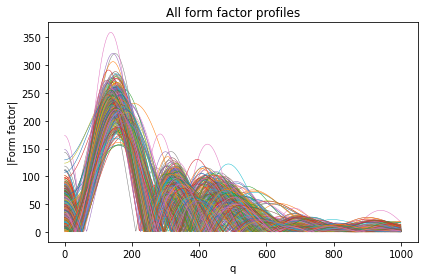

In [23]:
fig, ax = plt.subplots()
ax = plot_form_factors_to_ax(ax, sim_FF_df, x_axis_label_ff, y_axis_label_ff)
plt.title("All form factor profiles")
plt.tight_layout()
plt.show()

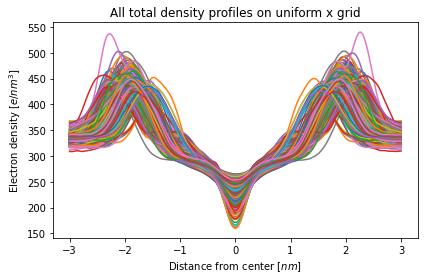

In [24]:
# Plot total density profiles on uniform x grid
fig, ax = plt.subplots()
ax = plot_total_densities_to_ax(
    ax, uniform_x_range, sim_TD_y_df, x_axis_label_td, y_axis_label_td
)
plt.title("All total density profiles on uniform x grid")
plt.tight_layout()
plt.show()

## Split data into train and test sets

The train/test split is highly influential on the model performance evaluation at the end of the notebook, as some cases are harder than other and are not considered if they end up in the train set.  
Therefore, to see how the models performance varies with the split, the split, model training and evaluation steps should be rerun with several different splits to get a better idea. 

In [25]:
train_input, test_input, train_output, test_output = train_test_split(
    sim_FF_df, sim_TD_y_df, test_size=0.2, random_state=rng.integers(0, 999999999)
)

n_train = train_input.shape[0]
n_test = test_input.shape[0]
print("n_train:", n_train)
print("n_test:", n_test)

n_train: 365
n_test: 92


In [26]:
# Rescale input and output to unit ranges using min and max values of the train set
min_ff_train = train_input.values.min()
max_ff_train = train_input.values.max()
train_input = rescale_to_zero_centered_unit_range(
    train_input, min_ff_train, max_ff_train
)
test_input = rescale_to_zero_centered_unit_range(test_input, min_ff_train, max_ff_train)

# Output
min_td_y_train = train_output.values.min()
max_td_y_train = train_output.values.max()
train_output = rescale_to_zero_centered_unit_range(
    train_output, min_td_y_train, max_td_y_train
)
test_output = rescale_to_zero_centered_unit_range(
    test_output, min_td_y_train, max_td_y_train
)

In [27]:
train_input

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
550,-0.389145,-0.389255,-0.389586,-0.390137,-0.390907,-0.391897,-0.393106,-0.394533,-0.396178,-0.398038,...,-0.492646,-0.492850,-0.493049,-0.493244,-0.493436,-0.493623,-0.493805,-0.493984,-0.494158,-0.494328
581,-0.417753,-0.417814,-0.417997,-0.418302,-0.418728,-0.419275,-0.419944,-0.420734,-0.421645,-0.422676,...,-0.453086,-0.452938,-0.452798,-0.452666,-0.452540,-0.452423,-0.452313,-0.452211,-0.452116,-0.452029
325,-0.462576,-0.462643,-0.462843,-0.463177,-0.463644,-0.464245,-0.464978,-0.465844,-0.466842,-0.467972,...,-0.496689,-0.496829,-0.496969,-0.497110,-0.497251,-0.497393,-0.497536,-0.497679,-0.497822,-0.497965
346,-0.371338,-0.371406,-0.371610,-0.371950,-0.372426,-0.373037,-0.373783,-0.374665,-0.375681,-0.376831,...,-0.497852,-0.497960,-0.498070,-0.498180,-0.498291,-0.498403,-0.498516,-0.498630,-0.498744,-0.498859
76,-0.470685,-0.470754,-0.470959,-0.471301,-0.471779,-0.472394,-0.473145,-0.474031,-0.475053,-0.476210,...,-0.499275,-0.499296,-0.499317,-0.499338,-0.499358,-0.499379,-0.499400,-0.499420,-0.499441,-0.499461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,-0.328970,-0.329055,-0.329311,-0.329737,-0.330333,-0.331099,-0.332035,-0.333139,-0.334412,-0.335854,...,-0.490148,-0.490124,-0.490104,-0.490086,-0.490071,-0.490059,-0.490050,-0.490044,-0.490041,-0.490041
783,-0.412680,-0.412794,-0.413135,-0.413704,-0.414499,-0.415521,-0.416769,-0.418242,-0.419939,-0.421860,...,-0.484752,-0.484863,-0.484978,-0.485096,-0.485218,-0.485343,-0.485471,-0.485603,-0.485738,-0.485876
721,-0.268712,-0.268821,-0.269149,-0.269695,-0.270460,-0.271442,-0.272641,-0.274057,-0.275688,-0.277535,...,-0.488531,-0.489142,-0.489745,-0.490341,-0.490927,-0.491503,-0.492069,-0.492623,-0.493164,-0.493691
538,-0.336434,-0.336530,-0.336817,-0.337295,-0.337964,-0.338824,-0.339874,-0.341113,-0.342542,-0.344160,...,-0.495263,-0.495240,-0.495217,-0.495194,-0.495171,-0.495148,-0.495125,-0.495102,-0.495080,-0.495057


In [28]:
train_output

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
550,-0.019638,-0.016898,-0.013101,-0.007600,-0.000666,0.006933,0.014861,0.023561,0.033724,0.045623,...,0.047324,0.033681,0.022395,0.013552,0.006141,-0.000767,-0.007240,-0.012775,-0.017069,-0.020333
581,-0.081867,-0.081221,-0.081250,-0.081643,-0.081825,-0.081514,-0.080810,-0.079978,-0.079252,-0.078848,...,-0.078447,-0.079015,-0.080025,-0.080880,-0.081306,-0.081361,-0.081267,-0.081256,-0.081598,-0.082386
325,-0.053420,-0.053374,-0.052622,-0.051966,-0.052004,-0.052336,-0.052256,-0.051664,-0.050588,-0.048683,...,-0.047951,-0.049194,-0.049440,-0.049059,-0.049557,-0.051639,-0.054327,-0.055818,-0.055298,-0.053578
346,-0.054199,-0.054932,-0.054627,-0.054054,-0.053584,-0.052977,-0.052336,-0.052302,-0.052867,-0.052832,...,-0.050462,-0.052935,-0.053936,-0.052695,-0.050935,-0.050946,-0.052916,-0.054810,-0.055039,-0.054000
76,-0.027831,-0.028018,-0.027760,-0.027022,-0.026025,-0.024659,-0.022660,-0.020121,-0.017692,-0.015624,...,-0.015601,-0.017863,-0.020427,-0.022956,-0.024599,-0.025426,-0.026125,-0.027159,-0.028020,-0.028228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,-0.051420,-0.051664,-0.051864,-0.051613,-0.050729,-0.049371,-0.047791,-0.046143,-0.044370,-0.042209,...,-0.042217,-0.044532,-0.046929,-0.048954,-0.050293,-0.051117,-0.051496,-0.051311,-0.050927,-0.051208
783,0.005357,0.008121,0.011368,0.015269,0.019471,0.023420,0.026976,0.030667,0.035275,0.041133,...,0.041850,0.036822,0.031536,0.026369,0.022302,0.019690,0.017683,0.015050,0.011443,0.007629
721,-0.049511,-0.047633,-0.045193,-0.042381,-0.039162,-0.035175,-0.030004,-0.023472,-0.015598,-0.006327,...,-0.007823,-0.017060,-0.024188,-0.030026,-0.035210,-0.039734,-0.043250,-0.045686,-0.047476,-0.049167
538,-0.035279,-0.035546,-0.035646,-0.035281,-0.034588,-0.033704,-0.032508,-0.030887,-0.028961,-0.026864,...,-0.027515,-0.029145,-0.030889,-0.032654,-0.033963,-0.034556,-0.034599,-0.034495,-0.034621,-0.035140


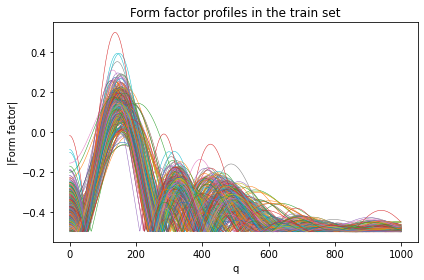

In [29]:
fig, ax = plt.subplots()
ax = plot_form_factors_to_ax(ax, train_input, x_axis_label_ff, y_axis_label_ff)
plt.title("Form factor profiles in the train set")
plt.tight_layout()
plt.show()

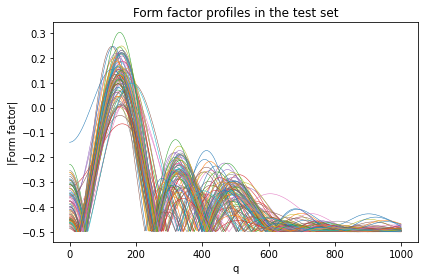

In [30]:
fig, ax = plt.subplots()
ax = plot_form_factors_to_ax(ax, test_input, x_axis_label_ff, y_axis_label_ff)
plt.title("Form factor profiles in the test set")
plt.tight_layout()
plt.show()

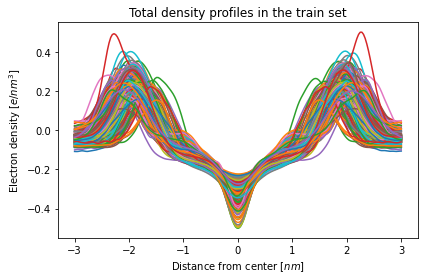

In [31]:
# Plot total density profiles on uniform x grid
fig, ax = plt.subplots()
ax = plot_total_densities_to_ax(
    ax, uniform_x_range, train_output, x_axis_label_td, y_axis_label_td
)
plt.title("Total density profiles in the train set")
plt.tight_layout()
plt.show()

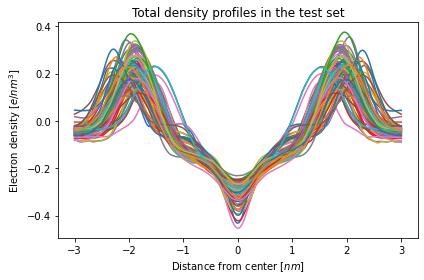

In [32]:
# Plot total density profiles on uniform x grid
fig, ax = plt.subplots()
ax = plot_total_densities_to_ax(
    ax, uniform_x_range, test_output, x_axis_label_td, y_axis_label_td
)
plt.title("Total density profiles in the test set")
plt.tight_layout()
plt.show()

## Adding simulated noise to the data to make it more realistic

In experimental data, experimental noise in the form factors will make the prediction problem harder. To emulate this and explore how well the model would do in such cases, we can add noise to the form factors before making the prediction.  

If the goal is to be applied to experimental data, the noise should be as realistic as possible, and the models should be compared based on how well they perform on 
noisy data.  

Experimental form factors are typically more noisy for higher q values, so the simulated noise reflects this, where the noise magnitude follows the sigmoid function below.

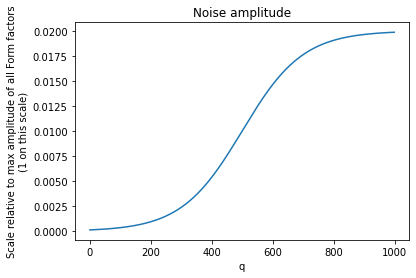

In [33]:
# Set the maximum noise magnitude at the highest q, and add noise to the standardized data
# Adjust the parameters here to alter how the noise magnitude changes with q
max_noise_magnitude = 0.02  # The maximum amplitude of the noise (occurs at the highest q value), relative to max amplitude of all Form factors (1 on this scale)
steepness = 10  # Controls how quickly the sigmoid transitions from 0 to max_noise_magnitude. Higher values make the transition sharper around the midpoint.
probability_of_noise = 1.0  # Introduce a chance that some form factors will be noise free by setting this value to a number below 1.

# Array of values from 0 to 1 in the dimension of q, to make the sigmoid
fraction_array = np.linspace(0.0, 1.0, required_form_factor_dimension)

noise_amplitudes = max_noise_magnitude * (
    1.0 / (1.0 + np.exp(-steepness * (fraction_array - 0.5)))
)
plt.plot(noise_amplitudes)
plt.title("Noise amplitude")
plt.ylabel("Scale relative to max amplitude of all Form factors\n(1 on this scale)")
plt.xlabel("q")
plt.show()

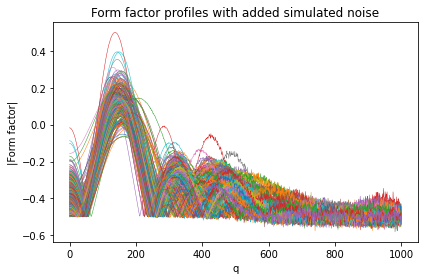

In [34]:
# Add noise to the form factors in train and test data
train_input_with_simulated_noise = add_noise_to_form_factor(
    train_input,
    max_noise_magnitude=max_noise_magnitude,
    probability_of_noise=probability_of_noise,
)
test_input_with_simulated_noise = add_noise_to_form_factor(
    test_input,
    max_noise_magnitude=max_noise_magnitude,
    probability_of_noise=probability_of_noise,
)

fig, ax = plt.subplots()
ax = plot_form_factors_to_ax(
    ax, train_input_with_simulated_noise, x_axis_label_ff, y_axis_label_ff
)
plt.title("Form factor profiles with added simulated noise")
plt.tight_layout()
plt.show()

### Comment out this code block (and rerun the entire notebook) to not add noise to the data.

In [35]:
# Add noise to the data
train_input = train_input_with_simulated_noise
test_input = test_input_with_simulated_noise

## Define different neural network arhcitectures

Types of neural networks to compare:  
- Fully connected, with one or more hidden layers
- Convolutional network

## Define a fully connected neural network and optimize it through hyperparameter tuning

Use [GridSearchCV](https://scikit-learn.org/1.6/modules/generated/sklearn.model_selection.GridSearchCV.html) from Scikit-learn to find the best hyperparameters (for the current train/test split) through k-fold cross-validation. 

In [36]:
# Settings for hyperparameter tuning of both fully connected and convolutional neural networks
k_folds = 3

In [37]:
# Wrap the Keras neural network model from build_fully_connected_model model so it can be used by scikit-learn
# NOTE: We pass the callable via `model=build_fully_connected_model` in newer SciKeras versions

regressor = KerasRegressor(
    model=build_fully_connected_model,
    verbose=0,
    # Default model-building params (can also be overridden in param_grid)
    input_dim=required_form_factor_dimension,
    output_dim=uniform_x_range_dimension,
    # Default training params (overridden by param_grid if specified)
    epochs=[500],
    batch_size=128,
)

In [38]:
# Define grid of hyperparameter values to search over
# Note: model-building params need the prefix "model__"

demo_single_model = {
    "model__hidden_layer_dims": [
        (128, 256, 256),
    ],
    "batch_size": [16],
    "epochs": [100],
}

demo_param_grid = {
    "model__hidden_layer_dims": [
        (128,),
        (
            128,
            256,
        ),
        (128, 256, 256),
    ],
    "batch_size": [16, 32],
    "epochs": [50, 100],
}

performance_param_grid = {
    "model__hidden_layer_dims": [
        (10000,),
        (
            10000,
            10000,
        ),
        (1024, 1024, 1024, 1024),
        (1024, 1024, 1024, 1024, 1024),
    ],
    "batch_size": [16],
    "epochs": [500],
}

performance_single_model = {  # best model among the options in performance_param_grid with the current train/test split
    "model__hidden_layer_dims": [
        (1024, 1024, 1024, 1024),
    ],
    "batch_size": [16],
    "epochs": [500],
}

# Change this line to e.g. performance_param_grid if you want high performance. It will take significantly longer time to run.
param_grid = performance_single_model  # demo_single_model

In [39]:
# Grid search CV to find the best parameters for the fully connected model
tf.get_logger().setLevel(
    "ERROR"
)  # If necessary, use this line to suppress warnings about retracing when the hidden layer dimension changes

# Create the GridSearchCV object
grid = GridSearchCV(
    estimator=regressor,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",  # The metric used to compare models against each other
    n_jobs=-1,  # use all available cores
    cv=k_folds,  # Number of folds (k) in the k-fold cross-validation
    verbose=1,
    refit=True,  # When true, the best model is automatically refit to the entire train set
    error_score="raise",  # raise errors so we can see them clearly
)

# Fit the GridSearchCV
general_start_time = time.time()
grid_result = grid.fit(train_input, train_output)
# Time use
general_end_time = time.time()
print("Used time: " + str(general_end_time - general_start_time) + " seconds")

# Print the results
print(f"Best Score: {grid_result.best_score_}")
print(f"Best Params: {grid_result.best_params_}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits


E0000 00:00:1747226619.843507   38513 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747226619.846774   38513 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747226619.857775   38513 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747226619.857818   38513 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747226619.857823   38513 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747226619.857827   38513 computation_placer.cc:177] computation placer already registered. Please check linka

Used time: 1302.8804733753204 seconds
Best Score: -0.0001431162745573717
Best Params: {'batch_size': 16, 'epochs': 500, 'model__hidden_layer_dims': (1024, 1024, 1024, 1024)}


In [40]:
# Take the model with the best parameters, which has been retrained on the entire train set when refit=true in GridSearchCV
best_model_object = grid_result.best_estimator_
best_model = best_model_object.model_
best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,025,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │       205,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,515,298 (66.82 MB)

 Trainable params: 4,378,824 (16.70 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,136,474 (50.11 MB)

## Define a convolutional network and optimize it through hyperparameter tuning

In [41]:
# Wrap the convolutional model so it can be used by scikit-learn
regressor_conv = KerasRegressor(
    model=build_convolution_model,
    verbose=0,
    # Default training params (overridden by param_grid if specified)
    epochs=[500],
    batch_size=128,
    # Default model-building params (can also be overridden in param_grid)
    input_dim=required_form_factor_dimension,
    output_dim=uniform_x_range_dimension,
    kernel_size=3,
    activation_function="relu",
)

In [42]:
# Define the param grid
# Note: Model-level params are prefixed with "model__"

demo_single_model_conv = {
    "model__kernel_size": [3],
    "model__activation_function": ["relu"],
    "model__hidden_layer_filters": [
        (16, 32, 32, 64),
    ],
    "batch_size": [16],
    "epochs": [25],
}

demo_grid_conv = {
    "model__kernel_size": [3, 5],
    "model__activation_function": ["relu"],
    "model__hidden_layer_filters": [
        (16, 32),
        (16, 32, 64),
        (16, 32, 64, 128),
    ],
    "batch_size": [16, 32],
    "epochs": [10, 25],
}

performance_grid_conv = {
    "model__kernel_size": [3, 5],
    "model__activation_function": ["relu"],
    "model__hidden_layer_filters": [
        (32, 64, 128),
        (32, 64, 64, 64),
        (16, 32, 64, 128),
        (32, 64, 128, 64),
        (32, 64, 128, 128),
    ],
    "batch_size": [32],
    "epochs": [500],
}

performance_single_model_conv = {  # best model among the options in performance_grid_conv with the current train/test split
    "model__kernel_size": [5],
    "model__activation_function": ["relu"],
    "model__hidden_layer_filters": [
        (16, 32, 64, 128),
    ],
    "batch_size": [32],
    "epochs": [500],
}

# Change this line to e.g. performance_single_model_conv if you want high performance. It will take significantly longer time to run.
param_grid_conv = performance_single_model_conv  # demo_single_model_conv

In [43]:
# Suppress retracing warnings
tf.get_logger().setLevel("ERROR")

# Create the GridSearchCV object
grid_conv = GridSearchCV(
    estimator=regressor_conv,
    param_grid=param_grid_conv,
    scoring="neg_mean_squared_error",  # or another regression metric
    n_jobs=-1,
    cv=k_folds,  # 2-fold cross-validation
    verbose=1,
    refit=True,  # Refit best model on entire training set after search
)

# For 1D convolution, reshape to (num_samples, required_form_factor_dimension, 1)
train_input_reshaped = np.expand_dims(
    train_input, axis=-1
)  # shape: (N, required_form_factor_dimension, 1)

general_start_time = time.time()
grid_result_conv = grid_conv.fit(train_input_reshaped, train_output)
general_end_time = time.time()

print("Used time:", general_end_time - general_start_time, "seconds")

print(f"Best Score: {grid_result_conv.best_score_}")
print(f"Best Params: {grid_result_conv.best_params_}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits


E0000 00:00:1747227922.767510   97309 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747227922.771036   97309 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747227922.781190   97309 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747227922.781230   97309 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747227922.781232   97309 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747227922.781235   97309 computation_placer.cc:177] computation placer already registered. Please check linka

Used time: 422.95903611183167 seconds
Best Score: -0.00023687404005543215
Best Params: {'batch_size': 32, 'epochs': 500, 'model__activation_function': 'relu', 'model__hidden_layer_filters': (16, 32, 64, 128), 'model__kernel_size': 5}


In [44]:
# Take the model with the best parameters, which has been retrained on the entire train set when refit=true in GridSearchCV
best_cnn_model = grid_result_conv.best_estimator_
best_cnn_model.model_.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1000, 16)       │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 500, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 500, 32)        │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 250, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 250, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 125, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 125, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 62, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7936)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │     1,587,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,565,922 (25.05 MB)

 Trainable params: 1,641,480 (6.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,924,442 (18.79 MB)

## Evaluate the neural networks on the test set

Evaluate the network's performance by comparing predictions to true test case values.

### Visualize predictive accuracy by plotting truth and predictions together

In [45]:
predictions = pd.DataFrame(best_model.predict(test_input), index=test_output.index)
predictions_conv = pd.DataFrame(
    best_cnn_model.model_.predict(test_input), index=test_output.index
)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [46]:
true_scale_predictions = rescale_back_to_true_range(
    predictions, min_td_y_train, max_td_y_train
)

In [47]:
# Scale up the output and predictions to match original range
# Important: Use min and max of train to scale up both the train and the test output, because train was used to scale both down

true_scale_train_output = rescale_back_to_true_range(
    train_output, min_td_y_train, max_td_y_train
)

true_scale_test_output = rescale_back_to_true_range(
    test_output,
    min_td_y_train,
    max_td_y_train,
)

true_scale_predictions = rescale_back_to_true_range(
    predictions, min_td_y_train, max_td_y_train
)

true_scale_predictions_conv = rescale_back_to_true_range(
    predictions_conv, min_td_y_train, max_td_y_train
)

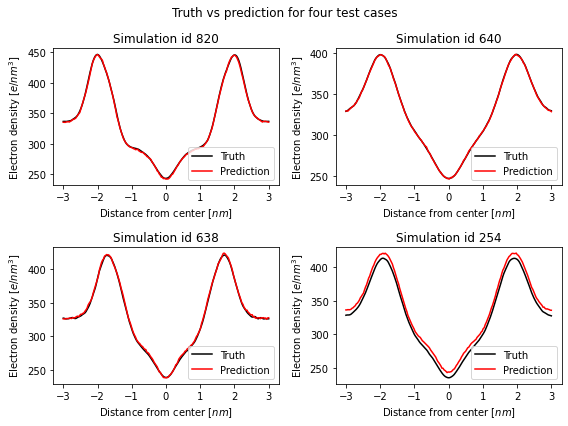

In [48]:
# Compare predictions to truth
# Rerun this block to cycle through different simulations, or use the line below to reset the plot counter
# start_of_test_case_plotting = 0

if "start_of_test_case_plotting" not in globals():
    start_of_test_case_plotting = 0

# Plot four comparisons
fig, axs = plt.subplots(nrows=2, ncols=2)
axs = axs.flatten()
plt.suptitle("Truth vs prediction for four test cases")
plot_index = 0
for system_counter, system_id in enumerate(true_scale_test_output.index):
    if system_counter >= start_of_test_case_plotting:
        axs[plot_index].plot(
            uniform_x_range,
            true_scale_test_output.loc[[system_id]].values.flatten(),
            color="k",
            linestyle="-",
            label="Truth",
        )
        axs[plot_index].plot(
            uniform_x_range,
            true_scale_predictions.loc[[system_id]].values.flatten(),
            color="r",
            linestyle="-",
            label="Prediction",
        )
        axs[plot_index].legend(loc="lower right")
        axs[plot_index].set_title("Simulation id " + str(system_id))
        axs[plot_index].set_xlabel(x_axis_label_td)
        axs[plot_index].set_ylabel(y_axis_label_td)
        plot_index += 1
        if plot_index >= 4:
            start_of_test_case_plotting = system_counter + 1
            break
fig.set_figheight(6)
fig.set_figwidth(8)
plt.tight_layout()
plt.show()

### Visualize predictive accuracy with the mean absolute deviation

In [49]:
# Compare the convolutional and fully connected networks by their median absolute deviations
prediction_residuals = np.array(
    [
        np.abs(
            true_scale_test_output.loc[[system_id]].values.flatten()
            - true_scale_predictions.loc[[system_id]].values.flatten()
        )
        for system_id in true_scale_test_output.index
    ]
)

prediction_residuals_conv = np.array(
    [
        np.abs(
            true_scale_test_output.loc[[system_id]].values.flatten()
            - true_scale_predictions_conv.loc[[system_id]].values.flatten()
        )
        for system_id in true_scale_test_output.index
    ]
)

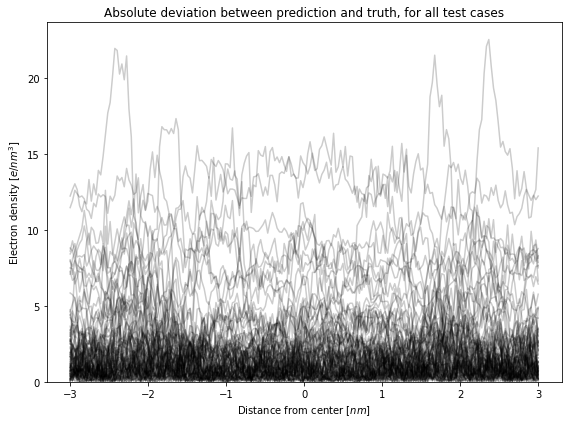

In [50]:
# Plot absolute deviation between prediction and truth, for all test cases
fig, ax = plt.subplots()
fig, ax = plot_absolute_deviation_to_ax(
    fig,
    ax,
    uniform_x_range,
    prediction_residuals,
    x_axis_label_td,
    y_axis_label_td,
    title="Absolute deviation between prediction and truth, for all test cases",
)
plt.show()

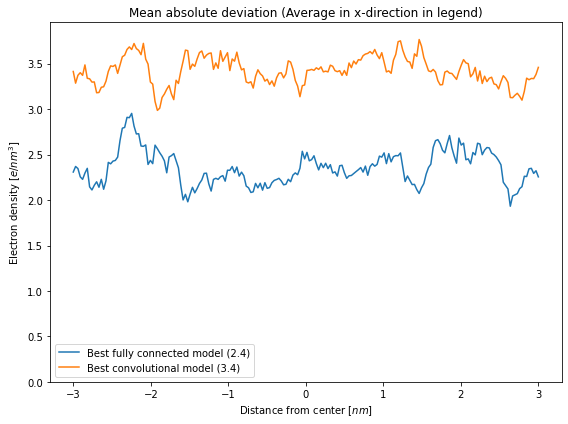

In [51]:
# Mean absolute deviation
mean_absolute_deviation = np.mean(
    prediction_residuals,
    axis=0,
)

mean_absolute_deviation_conv = np.mean(
    prediction_residuals_conv,
    axis=0,
)

fig, ax = plt.subplots()
fig, ax = plot_absolute_deviation_to_ax(
    fig,
    ax,
    uniform_x_range,
    mean_absolute_deviation,
    x_axis_label_td,
    y_axis_label_td,
    title="Mean absolute deviation (Average in x-direction in legend)",
    label="Best fully connected model ({:.1f})".format(
        np.mean(mean_absolute_deviation)
    ),
)
fig, ax = plot_absolute_deviation_to_ax(
    fig,
    ax,
    uniform_x_range,
    mean_absolute_deviation_conv,
    x_axis_label_td,
    y_axis_label_td,
    title="Mean absolute deviation (Average in x-direction in legend)",
    label="Best convolutional model ({:.1f})".format(
        np.mean(mean_absolute_deviation_conv)
    ),
)
ax.set_ylim(
    top=1.05 * max(max(mean_absolute_deviation), max(mean_absolute_deviation_conv))
)
plt.show()

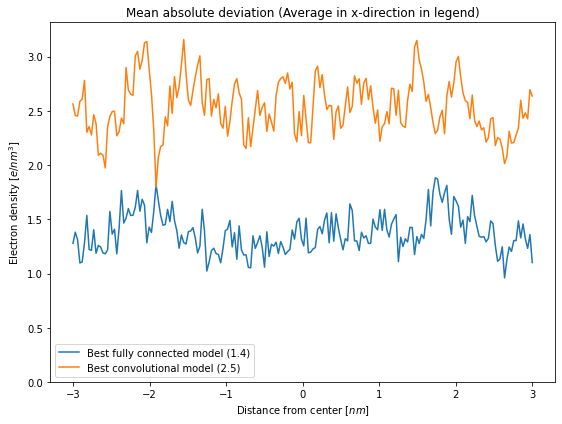

In [52]:
# Median absolute deviation
median_absolute_deviation = np.median(
    prediction_residuals,
    axis=0,
)

median_absolute_deviation_conv = np.median(
    prediction_residuals_conv,
    axis=0,
)

fig, ax = plt.subplots()
fig, ax = plot_absolute_deviation_to_ax(
    fig,
    ax,
    uniform_x_range,
    median_absolute_deviation,
    x_axis_label_td,
    y_axis_label_td,
    title="Mean absolute deviation (Average in x-direction in legend)",
    label="Best fully connected model ({:.1f})".format(
        np.mean(median_absolute_deviation)
    ),
)
fig, ax = plot_absolute_deviation_to_ax(
    fig,
    ax,
    uniform_x_range,
    median_absolute_deviation_conv,
    x_axis_label_td,
    y_axis_label_td,
    title="Mean absolute deviation (Average in x-direction in legend)",
    label="Best convolutional model ({:.1f})".format(
        np.mean(median_absolute_deviation_conv)
    ),
)
ax.set_ylim(
    top=1.05 * max(max(median_absolute_deviation), max(median_absolute_deviation_conv))
)
plt.show()

## Comparing models across different train/test splits
This script has used only one split between train and test, performing hyperparameter tuning by k-fold cross validation within the train set.  
As mentioned above, the random train test split has consequences for the model's performance.  
Therefore, when comparing models, it is important to limit the impact of this randomness.  

One way of doing this is k-fold cross validation, where the data is split into k non-overlapping subsets (or folds).  
Then the models should be compared by their average performance across the folds, using one fold as test set and the other as train set each time.  
Performance is measured using some predetermined metric like e.g. mean absolute deviation.  